In [5]:
import pandas as pd, xarray as xr, numpy as np, matplotlib.pyplot as plt, sklearn as sk, scipy

In [6]:
#Load in feature and label data
features = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_feature_data.csv')
labels = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_label_data.csv')
features = features.drop(columns = ['Unnamed: 0'])
labels = labels.drop(columns = ['Unnamed: 0'])

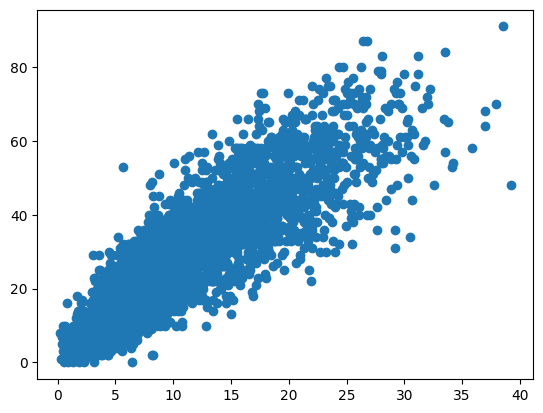

In [7]:
plt.scatter(features['ws8001'], labels['sknt'])

In [8]:
#Remove data points with more than half of features missing
dropidxs = []
for i in range(features.shape[0]):
  if pd.isnull(features).sum(axis = 1)[i] > 0.5*features.shape[1]:
    dropidxs.append(i)
print('Dropping ' + str(len(dropidxs)) + ' data points due to missing data')

features = features.drop(index = dropidxs).reset_index(drop=True)
labels = labels.drop(index = dropidxs).reset_index(drop=True)

Dropping 75 data points due to missing data


In [9]:
features

,ws80076,ws80074,ws80027,ws80026,ws80025,ws80024,ws80034,ws80035,ws80032,v80076,...,wd_5am_SW,wd_5am_W,wd_6hrchange_E,wd_6hrchange_N,wd_6hrchange_NE,wd_6hrchange_NW,wd_6hrchange_S,wd_6hrchange_SE,wd_6hrchange_SW,wd_6hrchange_W
0,-2.114274,-0.197411,-1.386205,-3.500478,-2.056756,-1.583615,-0.904934,-1.378075,0.678682,1.912058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.413929,-0.095486,1.460531,0.046602,-0.140648,1.365045,2.593176,1.087483,1.228131,1.281503,...,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0
2,-1.990047,-1.480498,1.476555,-0.513492,0.328568,-0.003943,1.023788,1.356299,1.027731,-0.251452,...,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0
3,-0.228084,-0.811954,1.327520,1.099436,0.036128,0.515566,0.386907,-0.092532,-0.128660,0.123359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.272282,-3.865910,3.558329,2.286047,-0.243216,-0.307581,-1.774134,-1.709768,-1.466553,0.036679,...,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,1.252909,0.902420,-1.392534,-0.139626,-2.537910,-0.490114,1.250670,-0.797125,1.740785,-0.610795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3261,0.448587,0.703200,0.695516,1.144103,-1.060397,1.398716,1.904370,-0.554743,0.505654,-0.287499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3262,2.419586,3.046813,-1.076736,1.342850,4.892933,1.970077,-0.984236,1.938621,-2.954312,-2.431503,...,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0
3263,-0.948465,4.114425,-5.016424,-5.964889,-1.743786,-0.901999,-0.657222,-1.499010,0.244777,1.351515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from numpy import random
#Set random seed for reproducible results
np.random.seed(1)

In [11]:
#Randomly select indices for training and testing data

other_indices = []
test_indices = []
validate_indices = []
train_indices = []

while len(train_indices) < int(np.round(features.shape[0] * 0.5)):
  i = np.random.randint(0, features.shape[0])
  if i not in train_indices:
    train_indices.append(i)

for i in range(features.shape[0]):
  if i not in train_indices:
    other_indices.append(i)

while len(validate_indices) < int(np.round(len(other_indices) * 0.6)):
  i = np.random.randint(0, len(other_indices))
  if other_indices[i] not in validate_indices:
    validate_indices.append(other_indices[i])

for i in range(len(other_indices)):
  if other_indices[i] not in validate_indices:
    test_indices.append(other_indices[i])


train_indices = np.array(train_indices)
validate_indices = np.array(validate_indices)
test_indices = np.array(test_indices)

In [12]:
#Split into training and testing features and labels
training_features_array = features.iloc[train_indices].values
training_labels_array = labels.iloc[train_indices, 1:].values
validate_features_array = features.iloc[validate_indices].values
validate_labels_array = labels.iloc[validate_indices, 1:].values
testing_features_array = features.iloc[test_indices].values
testing_labels_array = labels.iloc[test_indices, 1:].values

from sklearn.preprocessing import StandardScaler
all_features_array_scaled = StandardScaler().fit(np.array(features)).transform(np.array(features))

training_features_array_scaled = all_features_array_scaled[train_indices, :]
validate_features_array_scaled = all_features_array_scaled[validate_indices, :]
testing_features_array_scaled = all_features_array_scaled[test_indices, :]

<Axes: >

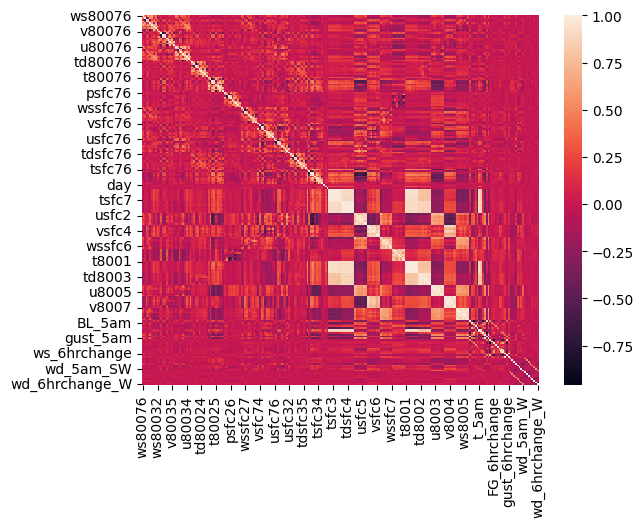

In [13]:
import seaborn as sns
sns.heatmap(features.corr())

Ridge regression with all features

0.8366964001956386


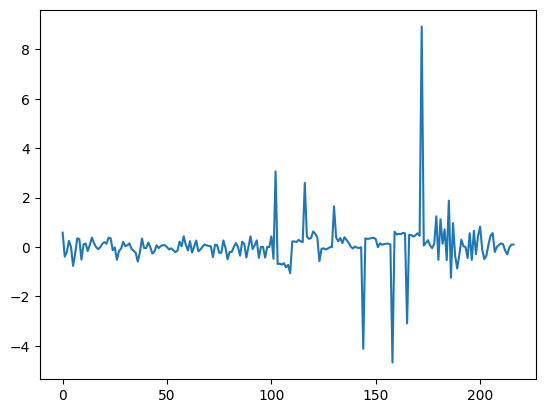

In [14]:
from sklearn.linear_model import Ridge

alpha_value = 1
rr = Ridge(alpha = alpha_value)
rr.fit(training_features_array_scaled, training_labels_array[:, 0])
print(rr.score(testing_features_array_scaled, testing_labels_array[:, 0]))
plt.plot(range(len(rr.coef_)), rr.coef_)


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(rr, training_features_array_scaled, training_labels_array[:, 0], scoring = 'neg_mean_squared_error')

array([-49.7863187 , -42.41493914, -38.08152402, -46.76241729,
       -49.06405924])

Linear model fit to all features of training data

In [16]:

from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(training_features_array_scaled, training_labels_array[:, 0])


In [17]:
predictions = linreg.predict(testing_features_array_scaled)

In [18]:
linreg.score(testing_features_array_scaled, testing_labels_array[:,0])

0.8362630225035588

Text(0.5, 1.0, 'Linear Regression, no normalization, all features')

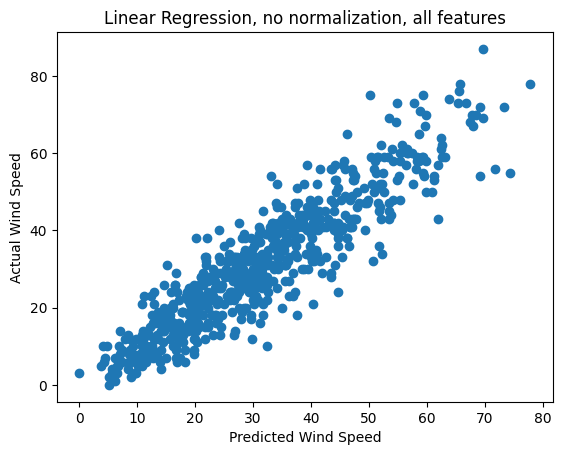

In [19]:
plt.scatter(predictions, testing_labels_array[:, 0])
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Linear Regression, no normalization, all features')

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(linreg, training_features_array_scaled, training_labels_array[:, 0], scoring = 'neg_mean_squared_error')

array([-49.92262041, -42.27363121, -38.07241427, -46.61508628,
       -49.80618263])

Simple decision tree fit to all features of training data

In [21]:
from sklearn.tree import DecisionTreeRegressor

Text(0.5, 1.0, 'Parameter tuning for decision tree')

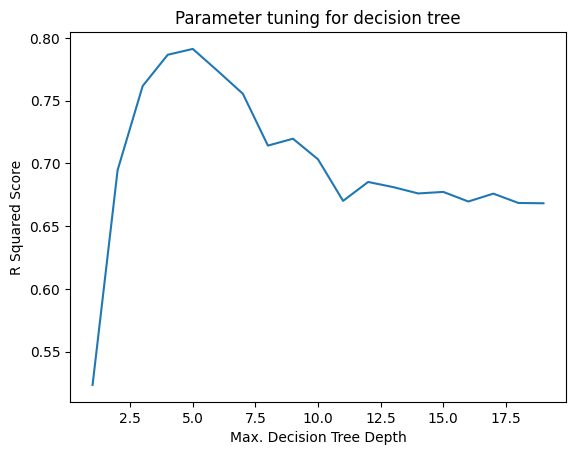

In [22]:
scores = []
for maxdepth in range(1, 20):
  dt = DecisionTreeRegressor(max_depth = maxdepth).fit(training_features_array, training_labels_array[:, 0])
  scores.append(dt.score(validate_features_array, validate_labels_array[:, 0]))

plt.plot(np.arange(1, 20), scores)
plt.xlabel('Max. Decision Tree Depth')
plt.ylabel('R Squared Score')
plt.title('Parameter tuning for decision tree')

In [23]:
#Make decision tree of optimal depth
dt = DecisionTreeRegressor(max_depth = 5).fit(training_features_array_scaled, training_labels_array[:, 0])

In [24]:
dtpredictions = dt.predict(testing_features_array_scaled)

Text(0.5, 1.0, 'Decision Tree Regressor trained on all features \n max_depth = 5')

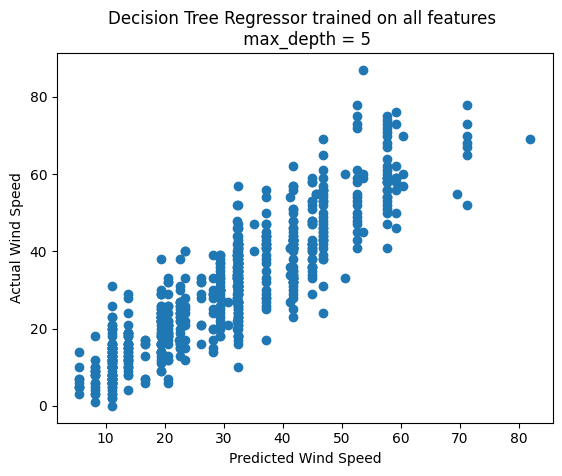

In [25]:
plt.scatter(dtpredictions, testing_labels_array[:, 0])
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Decision Tree Regressor trained on all features \n max_depth = 5')

In [27]:
#Visualize tree
import graphviz
from sklearn.tree import export_graphviz

def draw_tree(tree):
    dot_data = export_graphviz(tree, out_file=None, 
                         filled=True, 
                         feature_names = features.columns,
                         #impurity=True,
                         rounded=True,  
                         special_characters=True,
                              proportion = True)
    
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render('tree',view=True)

draw_tree(dt)

What about if we use the single best predictor (ws8001)?

(0.0, 90.0)

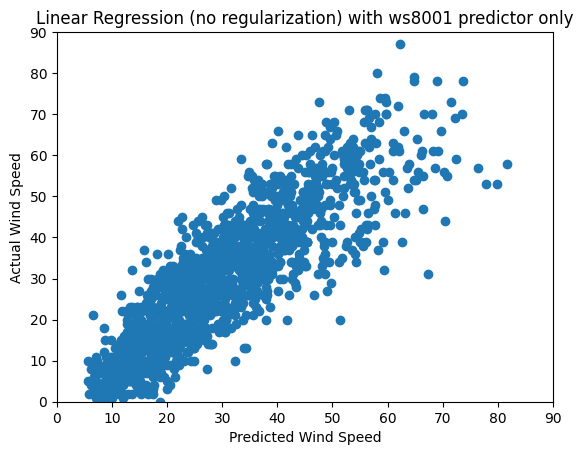

In [238]:
from sklearn.metrics import r2_score

#Plot lin reg result
#Note some pretty significant errors at higher wind speeds (could look into why these are happening, if we can improve in this area)
lr_onepredictor = LinearRegression().fit(training_features['ws8001'].values.reshape(-1, 1), training_labels['sknt'].values)
predictions_onepred = lr_onepredictor.predict(testing_features['ws8001'].values.reshape(-1, 1))
lr_onepredictor.score(testing_features['ws8001'].values.reshape(-1, 1), testing_labels['sknt'].values)
plt.scatter(predictions_onepred, testing_labels['sknt'])
plt.ylabel('Actual Wind Speed')
plt.xlabel('Predicted Wind Speed')
plt.title('Linear Regression (no regularization) with ws8001 predictor only')
plt.xlim([0, 90])
plt.ylim([0, 90])

What if we only look at winds greater than 40 kt?

In [50]:
#Get only winds above 40mph from training and testing data
g40_training_features = training_features[training_labels['sknt'] > 40]
g40_training_labels = training_labels[training_labels['sknt'] > 40]
g40_testing_features = testing_features[testing_labels['sknt'] > 40]
g40_testing_labels = testing_labels[testing_labels['sknt'] > 40]

In [51]:
from sklearn.metrics import r2_score

#Print score for regression using just ws8001 predictor
lr_g40 = LinearRegression().fit(g40_training_features['ws8001'].values.reshape(-1, 1), g40_training_labels['sknt'].values)
predictions_g40 = lr_g40.predict(g40_testing_features['ws8001'].values.reshape(-1, 1))
lr_g40.score(g40_testing_features['ws8001'].values.reshape(-1, 1), g40_testing_labels['sknt'].values)

0.3644258303665877

Text(0.5, 1.0, 'Linear Regression (no regularization) \n only ws8001 predictor used \n only for 40kt+ wind speeds')

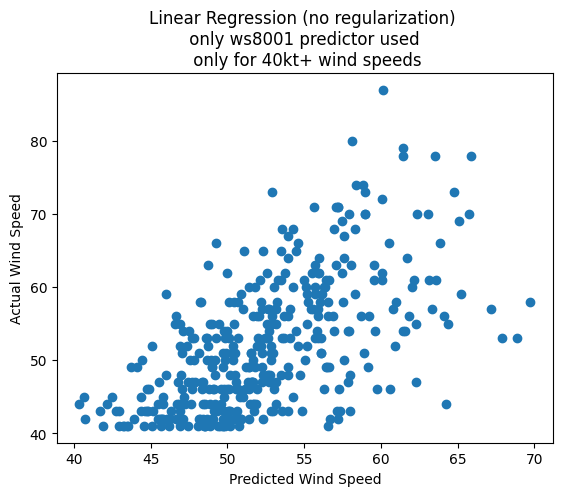

In [53]:
plt.scatter(predictions_g40, g40_testing_labels['sknt'].values)
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Linear Regression (no regularization) \n only ws8001 predictor used \n only for 40kt+ wind speeds')

In [54]:
from sklearn.metrics import r2_score

#Redo regression for 40kt+ but use all predictors (worse?? score, why)
#Maybe regularizarion could help here. Tune regularization parameter later.
lr_g40_mp = LinearRegression().fit(g40_training_features.values, g40_training_labels['sknt'].values)
predictions_g40_mp = lr_g40_mp.predict(g40_testing_features.values)
lr_g40_mp.score(g40_testing_features.values, g40_testing_labels['sknt'].values)

0.30246098158251544

Text(0.5, 1.0, 'Linear Regression (no regularization) \n all predictors used \n only for 40kt+ wind speeds')

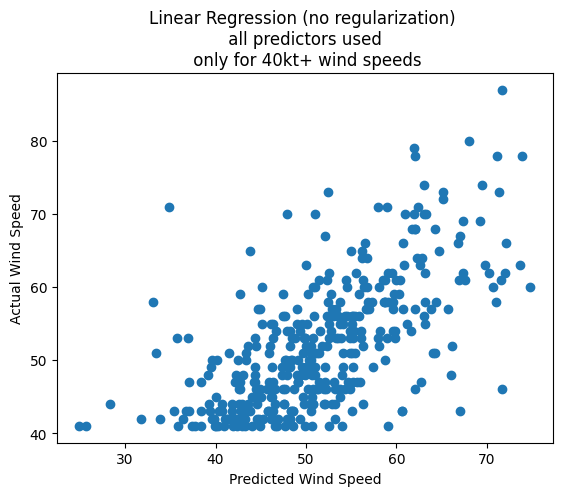

In [55]:
plt.scatter(predictions_g40_mp, g40_testing_labels['sknt'].values)
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Linear Regression (no regularization) \n all predictors used \n only for 40kt+ wind speeds')